In [42]:
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing import image as img_module
from tf_explain.callbacks.smoothgrad import SmoothGradCallback

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [3]:
training_set = train_datagen.flow_from_directory('../../Covid19-dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 251 images belonging to 3 classes.


In [4]:
test_set = test_datagen.flow_from_directory('../../Covid19-dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 66 images belonging to 3 classes.


In [5]:
model = load_model('../../models/covid/covid_vgg1.h5')

In [6]:
test_loss, test_accuracy = model.evaluate(test_set)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

3/3 [==============================] - 26s 7s/step - loss: 0.0872 - accuracy: 0.9697
Test Loss: 0.08715351670980453, Test Accuracy: 0.9696969985961914


In [44]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [46]:
# Prepare test data for the callback
X_test, y_test = next(test_set)

# Choose the target class index (the class you want to compute the saliency map for)
# 0 = normal, 1 = viral pneumonia, 2 = covid
class_index = 2

# Initialize the SmoothGradCallback
smoothgrad_callback = SmoothGradCallback(validation_data=(X_test, y_test), class_index=class_index, num_samples=25, noise=1., output_dir='smoothgrad_output')

# Train the model with the SmoothGradCallback
model.fit(training_set, epochs=10, callbacks=[smoothgrad_callback], validation_data=test_set)

Epoch 1/10
8/8 [==============================] - 132s 17s/step - loss: 0.0358 - accuracy: 0.9920 - val_loss: 0.0805 - val_accuracy: 0.9848
Epoch 2/10
8/8 [==============================] - 132s 17s/step - loss: 0.0350 - accuracy: 0.9880 - val_loss: 0.0792 - val_accuracy: 0.9848
Epoch 3/10
8/8 [==============================] - 134s 18s/step - loss: 0.0336 - accuracy: 0.9920 - val_loss: 0.0816 - val_accuracy: 1.0000
Epoch 4/10
8/8 [==============================] - 150s 19s/step - loss: 0.0359 - accuracy: 1.0000 - val_loss: 0.0758 - val_accuracy: 0.9848
Epoch 5/10
8/8 [==============================] - 142s 19s/step - loss: 0.0307 - accuracy: 0.9960 - val_loss: 0.0918 - val_accuracy: 0.9848
Epoch 6/10
8/8 [==============================] - 145s 19s/step - loss: 0.0297 - accuracy: 0.9960 - val_loss: 0.0726 - val_accuracy: 0.9848
Epoch 7/10
8/8 [==============================] - 147s 19s/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0680 - val_accuracy: 0.9848
Epoch 8/10
8/8 [====

In [47]:
model = load_model('../../models/covid/covid_vgg1.h5')

In [51]:
output_directory = '../../Output_Images/gradcam/'
output_name = 'smoothgrad.png'

In [52]:
# Import explainer
from tf_explain.core.smoothgrad import SmoothGrad

# Choose the target class index (the class you want to compute the saliency map for)
class_index = 2

# Instantiate the explainer
explainer = SmoothGrad()

# Call to explain() method
output = explainer.explain(training_set, model, class_index)

# Save output
explainer.save(output, output_directory, output_name)

ValueError: too many values to unpack (expected 2)

# old method

In [23]:
def add_noise_to_input(input_data, noise_level=0.1):
    input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)
    noise = tf.random.normal(input_data.shape, mean=0, stddev=noise_level, dtype=tf.float32)
    return input_data + noise

In [40]:
def smooth_grad(model, input_data, target_class_idx, noise_level=0.1, num_samples=50):
    # Initialize the accumulated gradients
    accumulated_gradients = np.zeros_like(input_data)

    # Generate noisy samples and compute gradients
    for _ in range(num_samples):
        noisy_input = add_noise_to_input(input_data, noise_level)
        with tf.GradientTape() as tape:
            tape.watch(noisy_input)
            predictions = model(noisy_input)
            target_class_output = predictions[:, target_class_idx]

        # Calculate gradients
        input_gradients = tape.gradient(target_class_output, noisy_input)

        # Accumulate gradients
        accumulated_gradients += input_gradients

    # Average gradients and normalize
    averaged_gradients = accumulated_gradients / num_samples
    normalized_gradients = (averaged_gradients - np.min(averaged_gradients)) / (np.max(averaged_gradients) - np.min(averaged_gradients))

    return normalized_gradients


In [25]:
# Load and preprocess the image
image_path = "../../Covid19-dataset/test/Covid/0100.jpeg"
img = img_module.load_img(image_path, target_size=(224, 224))
input_data = img_module.img_to_array(img) / 255.0

# Prepare the input data (shape should be [1, height, width, channels])
input_data = np.expand_dims(input_data, axis=0)

# Choose the target class index (the class you want to compute the saliency map for)
# 0 = normal, 1 = viral pneumonia, 2 = covid
target_class_idx = 2

# Compute SmoothGrad saliency map
saliency_map = smooth_grad(model, input_data, target_class_idx)

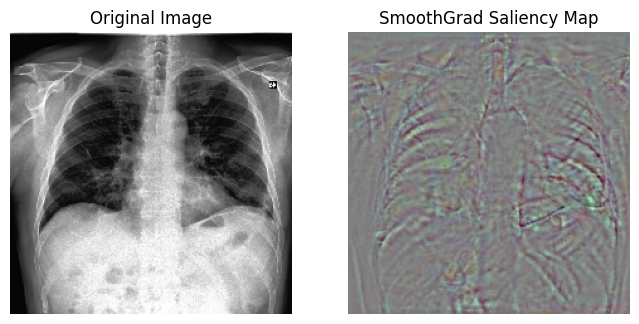

In [27]:
# Normalize the saliency map
saliency_map_min = tf.math.reduce_min(saliency_map)
saliency_map_max = tf.math.reduce_max(saliency_map)
saliency_map_normalized = (saliency_map - saliency_map_min) / (saliency_map_max - saliency_map_min)

# Convert the saliency_map_normalized to a NumPy array for displaying
saliency_map_normalized = saliency_map_normalized.numpy()

# Display the original image
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

# Display the saliency map
plt.subplot(1, 2, 2)
plt.title("SmoothGrad Saliency Map")
plt.imshow(saliency_map_normalized.squeeze(), cmap='viridis')
plt.axis('off')

plt.show()